In [1]:
from pathlib import Path
import os 
import sys
import numpy as np
import json

root = Path().resolve().parent

root_str = str(root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

if Path.cwd() != root:
    os.chdir(root)
    
from importlib import reload

## Rotowire

In [21]:
from jsonschema import Draft7Validator
from typing import Any, Dict, List, Tuple

def _ok(value: Any, allowed_types) -> bool:
    """Helper function to check key-wise type."""
    if not isinstance(allowed_types, list):
        allowed_types = [allowed_types]
    return (
        (value is None and "null" in allowed_types) or
        (isinstance(value, int)  and "integer" in allowed_types) or
        (isinstance(value, str)  and "string"  in allowed_types)
    )

def _score_section(data: List[Dict[str, Any]] | None,
                   definition: Dict[str, Any],
                   min_items: int | None,
                   max_items: int | None) -> Tuple[int, int]:
    """
    Returns (valid, total) for the section.
    If data is None (missing) or length violates min/max, returns (0, 1) → 0 %.
    """
    if data is None:
        return 0, 1                              # missing section → 0 %
    if (min_items and len(data) < min_items) or \
       (max_items and len(data) > max_items):
        return 0, 1                              # length violation → 0 %

    props     = definition["properties"]
    required  = set(definition.get("required", []))
    allow_add = definition.get("additionalProperties", False)

    total = valid = 0
    for obj in data:
        # Required keys first
        for key in required:
            total += 1
            if key in obj and _ok(obj[key], props[key]["type"]):
                valid += 1
                
        # Then looking at the other ones
        for key, val in obj.items():
            if key in required:
                continue
            total += 1
            if key in props:
                if _ok(val, props[key]["type"]):
                    valid += 1
            elif allow_add:
                valid += 1                        # Allowed extras
            # else: extra - invalid (counts as 0)

    return valid, total if total else (0,1)       # avoid div-by-zero

def compliance_breakdown(schema: Dict[str, Any],
                         record: Dict[str, Any]) -> Dict[str, float]:
    """Percentage compliance + real Draft-07 errors, handles all edge-cases."""
    validator = Draft7Validator(schema)
    errors    = list(validator.iter_errors(record))

    # Pull defs & array length rules from the schema
    team_def   = schema["definitions"]["team"]
    player_def = schema["definitions"]["player"]

    teams_schema   = schema["items"]["properties"]["teams"]
    players_schema = schema["items"]["properties"]["players"]

    t_valid, t_total = _score_section(
        record.get("teams"),
        team_def,
        teams_schema.get("minItems"),
        teams_schema.get("maxItems")
    )
    p_valid, p_total = _score_section(
        record.get("players"),
        player_def,
        players_schema.get("minItems"),
        players_schema.get("maxItems")
    )

    team_compliance = t_valid / t_total
    player_compliance = p_valid / p_total

    return {
        "team_compliance_%":   team_compliance * 100,
        "player_compliance_%": player_compliance * 100,
        "overall_compliance_%": float(np.mean([team_compliance, player_compliance])) * 100,
        "errors": errors
    }


In [ ]:
path = "data/clean/rotowire/"

# Example usage:
with open(path + "schema.json") as sf, open(path + "clean.json") as rf:
    schema = json.load(sf)
    record = json.load(rf)[0]["output"]

result = compliance_breakdown(schema, record)
print(f"Teams:  {result['team_compliance_%']:.1f}%")
print(f"Players:{result['player_compliance_%']:.1f}%")
print(f"Overall:{result['overall_compliance_%']:.1f}%")
for err in result["errors"]:
    print(f"– {err.message} (at {list(err.absolute_path)})")
print(result)

Teams:  100.0%
Players:100.0%
Overall:100.0%
{'team_compliance_%': 100.0, 'player_compliance_%': 100.0, 'overall_compliance_%': 100.0, 'errors': []}


In [4]:
record

{'teams': [{'team': 'Suns', 'losses': 38, 'total_points': 87, 'wins': 39},
  {'team': 'Jazz', 'losses': 42, 'total_points': 85, 'wins': 34}],
 'players': [{'player': 'Gordon Hayward',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': 18,
   'minutes_played': None,
   'points': 21,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Rudy Gobert',
   'assists': 2,
   'blocks': 1,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 38,
   'points': 8,
   'total_rebounds': 15,
   'steals': 1},
  {'player': 'Rodney Hood',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': None,
   'points': 17,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Brandan Wright',
   'assists': 1,
   'blocks': 4,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 33,
   'points': 14,
   'total_rebounds': 3,
   'stea

In [21]:
reload(src.evaluate)
from src.evaluate import RotowireEvaluator

eval = RotowireEvaluator(schema)

eval.compliance_breakdown(json.dumps(record))

{'is_valid': 1,
 'team_compliance_%': 1.0,
 'player_compliance_%': 1.0,
 'overall_compliance_%': 1.0,
 'errors': []}

In [22]:
eval.compliance_breakdown(str(record))

{'is_valid': 0,
 'team_compliance_%': 1.0,
 'player_compliance_%': 0.46296296296296297,
 'overall_compliance_%': 0.7314814814814815,
 'errors': []}

In [23]:
record_2 = """{'teams': [{'team': 'Suns', 'losses': 38, 'total_points': 87, 'wins': 39},
  {'team': 'Jazz', 'losses': 42, 'total_points': 85, 'wins': 34}],
 'players': [{'player': 'Gordon Hayward',
   'assists': null,
   'blocks': null,
   '3_pointers_made': null,
   'field_goals_attempted': 18,
   'minutes_played': null,
   'points': 21,
   'total_rebounds': null,
   'steals': null},
  {'player': 'Rudy Gobert',
   'assists': 2,
   'blocks': 1,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': 38,
   'points': 8,
   'total_rebounds': 15,
   'steals': 1},
  {'player': 'Rodney Hood',
   'assists': null,
   'blocks': null,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': null,
   'points': 17,
   'total_rebounds': null,
   'steals': null},
  {'player': 'Brandan Wright',
   'assists': 1,
   'blocks': 4,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': 33,
   'points': 14,
   'total_rebounds': 3,
   'steals': 3},
  {'player': 15,
   'assists': null,
   'blocks': null,
   '3_pointers_made': null,
   'field_goals_attempted': null,
   'minutes_played': null,
   'points': 4,
   'total_rebounds': null,
   'steals': null},
  {'player': 'Gerald Green',
   'assists': null,
   'blocks': null,
   '3_pointers_made': 3,
   'field_goals_attempted': null,
   'minutes_played': 22,
   'points': 24,
   'total_rebounds': null,
   'ste;als': null}}"""
   
eval.compliance_breakdown(record_2)

{'is_valid': 0,
 'team_compliance_%': 1.0,
 'player_compliance_%': 0.9629629629629629,
 'overall_compliance_%': 0.9814814814814814,
 'errors': []}

In [24]:
eval.evaluate_game(record, record)

{'ident_f1': 1.0,
 'object_attr_F1': 1.0,
 'object_value_acc': 1.0,
 'object_attribute_score': 1.0,
 'overall_score': 1.0}

In [11]:
record

{'teams': [{'team': 'Suns', 'losses': 38, 'total_points': 87, 'wins': 39},
  {'team': 'Jazz', 'losses': 42, 'total_points': 85, 'wins': 34}],
 'players': [{'player': 'Gordon Hayward',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': 18,
   'minutes_played': None,
   'points': 21,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Rudy Gobert',
   'assists': 2,
   'blocks': 1,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 38,
   'points': 8,
   'total_rebounds': 15,
   'steals': 1},
  {'player': 'Rodney Hood',
   'assists': None,
   'blocks': None,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': None,
   'points': 17,
   'total_rebounds': None,
   'steals': None},
  {'player': 'Brandan Wright',
   'assists': 1,
   'blocks': 4,
   '3_pointers_made': None,
   'field_goals_attempted': None,
   'minutes_played': 33,
   'points': 14,
   'total_rebounds': 3,
   'stea

### Another trial

In [24]:
from jsonschema import Draft7Validator
from typing import Any, Iterable, Mapping

# ── A ── count how many *primitive* checks a schema implies ────────────
def _leaf_count(schema: Mapping[str, Any]) -> int:
    t = schema.get("type")

    if t == "object":
        return sum(_leaf_count(s) for s in schema.get("properties", {}).values())
    if t == "array":
        return 1 + _leaf_count(schema.get("items", {}))          # 1 for the array itself
    return 1                                                     # scalar / “primitive”


# ── B ── resolve a JSON-Pointer (RFC 6901) inside *schema* ─────────────
def resolve_pointer(schema: Mapping[str, Any], pointer: str) -> Mapping[str, Any]:
    """
    Return the subschema addressed by *pointer* (e.g. "#/definitions/player").
    Accepts both absolute "#/…" and plain "/…" forms.
    """
    if pointer.startswith("#"):
        pointer = pointer[1:]
    if pointer.startswith("/"):
        pointer = pointer[1:]

    node: Mapping[str, Any] = schema
    for token in pointer.split("/"):
        # unescape
        token = token.replace("~1", "/").replace("~0", "~")
        node = node[token]
    return node


# ── C ── score data against *any* (sub)schema ──────────────────────────
def score_against_schema(schema: Mapping[str, Any], data: Any) -> dict:
    """
    Return {"percentage": float, "failures": list[ValidationError]}.
    """
    v = Draft7Validator(schema)
    errors = list(v.iter_errors(data))
    total_checks = _leaf_count(schema)
    pct = round(100 * (total_checks - len(errors)) / total_checks, 1) if total_checks else 100.0
    return {"percentage": pct, "failures": errors}

def score_collection(root_schema: Mapping[str, Any],
                     record: Mapping[str, Any],
                     collection_prop: str,
                     subschema_pointer: str) -> list[dict]:
    """
    • *collection_prop*        name of the property in *record*
    • *subschema_pointer*      JSON-Pointer to the element schema
    Returns a list with one report per element.
    """
    subschema = resolve_pointer(root_schema, subschema_pointer)
    collection: Iterable[Any] = record.get(collection_prop, [])
    return [score_against_schema(subschema, item) for item in collection]


root_schema = json.loads(open(r"data\clean\rotowire\schema.json").read())  # your Draft-7 file
with open(r"data\clean\rotowire\bench.json") as rf:
    record = json.load(rf)

game = record[0]["output"]
# Whole-record score (optional)
overall = score_against_schema(root_schema, game)
print("Overall:", overall["percentage"], "% valid")

# Per-team
team_reports = score_collection(root_schema, game,
                                collection_prop="teams",
                                subschema_pointer="#/definitions/team")

# Per-player
player_reports = score_collection(root_schema, game,
                                  collection_prop="players",
                                  subschema_pointer="#/definitions/player")

# Pretty-print
for i, rep in enumerate(team_reports, 1):
    print(f"Team {i}: {rep['percentage']} % valid")
for i, rep in enumerate(player_reports, 1):
    print(f"Player {i}: {rep['percentage']} % valid")



Overall: 100.0 % valid
Team 1: 100.0 % valid
Team 2: 100.0 % valid
Player 1: 100.0 % valid
Player 2: 100.0 % valid
Player 3: 100.0 % valid
Player 4: 100.0 % valid
Player 5: 100.0 % valid
Player 6: 100.0 % valid
Player 7: 100.0 % valid


## Wikibio

In [2]:
from src.evaluate import GeneralJsonSchemaEvaluator

with open(r"data\clean\2-wiki_bio\bench.json", "r") as f:
    data = json.load(f)
    
i = 23

validator = GeneralJsonSchemaEvaluator(data[i]["schema"])
validator.score_against_schema(data[i]["output"])

{'compliance': 1.0, 'compliance_errors': []}

In [3]:
output = {'occupation': 'television/film director, producer',
 'years_active': '19512009',
 'name': 'john rich',
 'death_phlace': 'los angeles, california, u.s.',
 'birth_place': 'rockaway beach, new york, u.s.',
 'death_date': '2012-01-295',
 'alma_mater': 'university of michigan',
 'birth_date': '1925-067'}

validator.score_against_schema(output)

{'compliance': 0.4,
 'compliance_errors': [<ValidationError: "'article_title' is a required property">,
  <ValidationError: "'death_place' is a required property">,
  <ValidationError: "'1925-067' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">,
  <ValidationError: "'2012-01-295' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">,
  <ValidationError: "Additional properties are not allowed ('death_phlace' was unexpected)">]}

In [4]:
from src.evaluate import WikiBioEvaluator

assessor = WikiBioEvaluator()
print(assessor.compute_compliance(json.dumps(output), data[i]["schema"]))
print(assessor.compute_correctness(data[i], {"output": output}))

{'is_valid': 1, 'compliance': 0.4, 'compliance_errors': [<ValidationError: "'article_title' is a required property">, <ValidationError: "'death_place' is a required property">, <ValidationError: "'1925-067' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">, <ValidationError: "'2012-01-295' does not match '^\\\\d{4}(-\\\\d{2}){0,1}(-\\\\d{2}){0,1}$'">, <ValidationError: "Additional properties are not allowed ('death_phlace' was unexpected)">]}
{'overall_score': 1.0, 'correctness_errors': []}


In [5]:
data[i]["output"]

{'occupation': 'television/film director, producer',
 'article_title': 'john rich (director)',
 'years_active': '19512009',
 'name': 'john rich',
 'death_place': 'los angeles, california, u.s.',
 'birth_place': 'rockaway beach, new york, u.s.',
 'death_date': '2012-01-29',
 'alma_mater': 'university of michigan',
 'birth_date': '1925-07'}

## Few nerds

In [2]:
with open(r"data\clean\3-few_nerd\parsed.json", "r") as f, open(r"data\clean\3-few_nerd\schema.json", "r") as sf:
    data = json.load(f)
    schema = json.load(sf)
    
data[43]

{'input': "Argentina 's Del Imaginario Discos also released the album in 2007 .",
 'output': {'art': None,
  'building': None,
  'event': None,
  'location': ['Argentina'],
  'organization': ['Del Imaginario Discos'],
  'other': None,
  'person': None,
  'product': None}}

In [3]:
from src.evaluate import GeneralJsonSchemaEvaluator
assessor = GeneralJsonSchemaEvaluator(schema)

assessor.score_against_schema(data[43]["output"])

{'compliance': 1.0, 'compliance_errors': []}

In [22]:
output = {'input': "Argentina 's Del Imaginario Discos also released the album in 2007 .",
 'output': {'art': None,
  'building': [],
  'event': [12],
  'location': ['Argentina'],
  'organization': ['Del Imaginario Discos'],
  'other': None,
  'product': "you",
  "him": None}}

assessor.score_against_schema(output["output"])


{'compliance': 0.4,
 'compliance_errors': [<ValidationError: "Additional properties are not allowed ('him' was unexpected)">,
  <ValidationError: "'person' is a required property">,
  <ValidationError: '[] should be non-empty'>,
  <ValidationError: "12 is not of type 'string'">,
  <ValidationError: "'you' is not of type 'array', 'null'">]}

In [25]:
import src.evaluate
reload(src.evaluate)
from src.evaluate import FewNerdsEvaluator

assessor_2 = FewNerdsEvaluator()
print(assessor_2.compute_compliance(data[43]["output"]))
print(assessor_2.compute_correctness(data[43]["output"], data[43]["output"]))

{'compliance': 1.0, 'compliance_errors': []}
{'overall_score': 1.0, 'correctness_errors': []}


In [26]:
print(assessor_2.compute_compliance(output["output"]))
print(assessor_2.compute_correctness(data[43]["output"], output["output"]))

{'compliance': 0.4, 'compliance_errors': [<ValidationError: "Additional properties are not allowed ('him' was unexpected)">, <ValidationError: "'person' is a required property">, <ValidationError: '[] should be non-empty'>, <ValidationError: "12 is not of type 'string'">, <ValidationError: "'you' is not of type 'array', 'null'">]}
{'overall_score': 0.5, 'correctness_errors': ["Spurious event: ['12']", "Spurious product: ['you']"]}


### Subset

In [37]:
ordered_clean_data = []
for i, record in enumerate(data):
    record["id"] = i
    ordered_clean_data.append({k: record[k] for k in sorted(record)})

with open(r"data\clean\3-few_nerd\clean.json", "w") as f:
    json.dump(ordered_clean_data, f, indent=2)

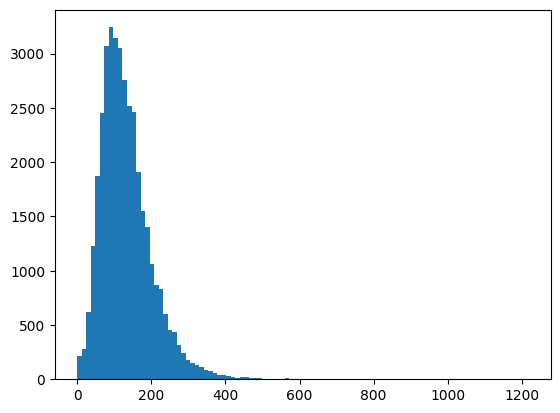

In [38]:
import matplotlib.pyplot as plt
length = []
for record in ordered_clean_data:
    length.append(len(record["input"]))

length = np.array(length)
plt.hist(length, bins=100);


In [46]:
subset = np.random.choice(np.array(ordered_clean_data)[length > 100], 100, replace=False).tolist()
subset

[{'id': 16119,
  'input': "The mission of the 303rd Military Intelligence Battalion , `` Longhorns , '' is to , on order , conduct multi-disciplined intelligence collection , exploitation , and limited analysis operations in support of the commander 's information requirements during worldwide contingency missions within assigned areas of a Division , Corps , or Joint Task Force area of operations .",
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': None,
   'organization': ['303rd Military Intelligence Battalion', 'Longhorns'],
   'other': None,
   'person': None,
   'product': None}},
 {'id': 29924,
  'input': 'This was officially launched in a ceremony at the Genting Highlands Fire and Rescue Station in Pahang on 21 February 1997 , by Prime Minister of Malaysia Mahathir Mohamad .',
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': ['Pahang', 'Malaysia'],
   'organization': ['Genting Highlands Fire', 'Rescue Station'],
   '

In [47]:
with open(r"data\clean\3-few_nerd\bench.json", "w") as f:
    json.dump(subset, f, indent=2)

In [48]:
subset[:5]

[{'id': 16119,
  'input': "The mission of the 303rd Military Intelligence Battalion , `` Longhorns , '' is to , on order , conduct multi-disciplined intelligence collection , exploitation , and limited analysis operations in support of the commander 's information requirements during worldwide contingency missions within assigned areas of a Division , Corps , or Joint Task Force area of operations .",
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': None,
   'organization': ['303rd Military Intelligence Battalion', 'Longhorns'],
   'other': None,
   'person': None,
   'product': None}},
 {'id': 29924,
  'input': 'This was officially launched in a ceremony at the Genting Highlands Fire and Rescue Station in Pahang on 21 February 1997 , by Prime Minister of Malaysia Mahathir Mohamad .',
  'output': {'art': None,
   'building': None,
   'event': None,
   'location': ['Pahang', 'Malaysia'],
   'organization': ['Genting Highlands Fire', 'Rescue Station'],
   '

## Top v1

In [58]:
with open(r"data\clean\4-TOPv1\parsed.json", "r") as f, open(r"data\clean\4-TOPv1\schema.json", "r") as sf, open(r"data\clean\4-TOPv1\schema_base.json", "r") as sf_base:
    data = json.load(f)
    schema = json.load(sf)
    schema_base = json.load(sf_base)
    
data[645]

{'input': 'family holiday events near me this weekend',
 'output': {'intent': 'GET_EVENT',
  'slots': {'ATTRIBUTE_EVENT': 'family',
   'DATE_TIME': ['holiday', 'this weekend'],
   'LOCATION': {'intent': 'GET_LOCATION',
    'slots': {'SEARCH_RADIUS': 'near', 'LOCATION_USER': 'me'}}}}}

In [59]:
evaluator = GeneralJsonSchemaEvaluator(schema_base)
evaluator.score_against_schema(data[54]["output"])

{'compliance': 1.0, 'compliance_errors': []}

In [ ]:
for record in data:
    res = evaluator.score_against_schema(record["output"])
    if res["compliance"] < 0.5:
        print(f"Record {record['id']} has low compliance: {res['compliance']:.2f}")
        print(record["output"])
        print()